In [0]:
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
#기본 변경옵션

total_epoch = 100 # epoch 수 설정
batch_size = 100 # 배치 사이즈
learning_rate = 0.0002 # 학습률
# 신경망 레이어 구성 옵션
n_hidden = 256 # 은닉층 노드
n_input = 28 * 28 #784 # 입력
n_noise = 128 # 생성기의 입력값으로 사용할 노이즈의 크기


In [0]:
##GAN에 대한 설명

#실제 데이터 ------------(img_A)---------(D) (입력층) n_input=> (은닉층) n_hidden => (출력층 ) 1 ====> loss: maximum                                          l
#                                         l                                       (1은 0~1 사이의 값. 정확도)
#                                      (img_B)
#             n_noise         n_input     l
#랜덤 데이터----------  (G)  -------------l



#img_A : 실제 이미지
#img_B : 모델의 이미지  img_A와 비슷하게 만들어야 함 (==> loss가 최대가 되어야 가능)

In [0]:
# GAN 도 Unsupervised 학습이므로 Autoencoder 처럼 Y 를 사용하지 않습니다.
X=tf.placeholder(tf.float32,[None,n_input])
Z=tf.placeholder(tf.float32,[None,n_noise])

In [0]:
# 생성자(G) 신경망 구성

##입력층 -> 은닉층
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))

## 은닉층-> 출력층
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

In [0]:
#판별자(D) 신경망 구성

##입력층 -> 은닉층
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))

## 은닉층-> 출력층
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01)) 
# 판별기의 최종 결과값은 얼마나 진짜와 가깝냐를 판단하는 한 개의 스칼라값입니다. 그래서 '1'
D_b2 = tf.Variable(tf.zeros([1]))

### 노이즈 데이터 발생을 위한 노이즈 생성함수


def generator(데이터 개수, 노이즈 개수):

return np.random_normal(size=(batch_size,n_noise))

In [0]:
def get_noise(batch_size,n_noise):

  return np.random.normal(size=(batch_size,n_noise))

In [0]:
#무작위 생성한 노이즈를 받아, 가중치와 편향을 반영하여 은닉층 구성.
#sigmoid 함수를 이용하여 최종 결과값 0~1 사이의 값 반환


def generator(noise_z):
  hidden = tf.nn.relu( tf.matmul(noise_z, G_W1) + G_b1)
  output = tf.nn.sigmoid( tf.matmul(hidden, G_W2) + G_b2)
  return output

In [0]:
def discriminator(inputs):
  hidden = tf.nn.relu( tf.matmul(inputs, D_W1) + D_b1)
  output = tf.nn.sigmoid( tf.matmul(hidden, D_W2) + D_b2)
  return output

In [0]:
#생성자 신경망
G = generator(Z)

#판별자 신경망
D_fake = discriminator(G) # 노이즈를 이용해 생성한 이미지가 진짜 이미지인지 판별한 값

#실제 이미지
D_real = discriminator(X) # 진짜 이미지를 이용해 판별한 값

## GAN의 모델의 최적화
-loss_G(생성자)와 loss_D(구분자)를 최대화 하는 것.

*  단, 서로의 손실이 연관되어 있어, 두 손실값이 같이 증가가 어려움.


-loss_D를 최대화하기 위해서는 D_fake값을 최소화시킴.


-판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)


-가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_fake)

In [0]:
#경찰관
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))


#범죄자  #위조 지폐범의 학습은 D_fake(가짜)값을 최대화 한다.
loss_G = tf.reduce_mean(tf.log(D_fake))




## GAN의 학습은 loss_D와 loss_G 를 최대화 하는것.

In [0]:
#최적화 함수 optimizer

##사용되는 변수
D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]


## GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만,
## minimize 하는 최적화 함수를 사용하기 때문에
## 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.

train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list)

train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=G_var_list)

In [0]:
#초기화

init=tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)

In [0]:
total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

In [0]:
#실제 데이터 ------------(img_A)---------(D) (입력층) n_input=> (은닉층) n_hidden => (출력층 ) 1 ====> loss: maximum                                          l
 #                                        l                                       (1은 0~1 사이의 값. 정확도)
  #                                    (img_B)
   #          n_noise         n_input     l
#랜덤 데이터----------  (G)  -------------l



#img_A : 실제 이미지
#img_B : 모델의 이미지  img_A와 비슷하게 만들어야 함 (==> loss가 최대가 되어야 가능)

In [0]:
!mkdir samples  #samples 란 이름의 파일 생성

mkdir: cannot create directory ‘samples’: File exists


In [0]:
%%time

for epoch in range(total_epoch):
  for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    noise = get_noise(batch_size, n_noise)
    # 판별기와 생성기 신경망을 각각 학습시킵니다.
    _, loss_val_D = sess.run([train_D, loss_D],
                           feed_dict={X: batch_xs, Z: noise})
 
    _, loss_val_G = sess.run([train_G, loss_G],
                           feed_dict={Z: noise})
  
  print('Epoch:', '%04d' % epoch,
        '판별망 성능: {:.4}'.format(loss_val_D),
        '생성망 성능: {:.4}'.format(loss_val_G))
#########
# 학습이 되어가는 모습을 보기 위해 주기적으로 이미지를 생성하여 저장
######
  if epoch == 0 or (epoch + 1) % 10 == 0:
    sample_size = 10
    noise = get_noise(sample_size, n_noise) # 노이즈 생성.
    samples = sess.run(G, feed_dict={Z: noise})
    fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
    for i in range(sample_size):
      ax[i].set_axis_off()
      ax[i].imshow(np.reshape(samples[i], (28, 28)))
  plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
  plt.close(fig)


print('최적화 완료!')

Epoch: 0000 판별망 성능: -0.5799 생성망 성능: -2.249
Epoch: 0001 판별망 성능: -0.5505 생성망 성능: -2.085
Epoch: 0002 판별망 성능: -0.5729 생성망 성능: -2.248
Epoch: 0003 판별망 성능: -0.5949 생성망 성능: -2.116
Epoch: 0004 판별망 성능: -0.7463 생성망 성능: -2.212
Epoch: 0005 판별망 성능: -0.6467 생성망 성능: -1.97
Epoch: 0006 판별망 성능: -0.674 생성망 성능: -2.098
Epoch: 0007 판별망 성능: -0.5441 생성망 성능: -2.243
Epoch: 0008 판별망 성능: -0.7236 생성망 성능: -2.214
Epoch: 0009 판별망 성능: -0.5623 생성망 성능: -2.292
Epoch: 0010 판별망 성능: -0.601 생성망 성능: -2.325
Epoch: 0011 판별망 성능: -0.5341 생성망 성능: -2.37
Epoch: 0012 판별망 성능: -0.7435 생성망 성능: -2.385
Epoch: 0013 판별망 성능: -0.5401 생성망 성능: -2.144
Epoch: 0014 판별망 성능: -0.498 생성망 성능: -2.41
Epoch: 0015 판별망 성능: -0.5542 생성망 성능: -2.508
Epoch: 0016 판별망 성능: -0.5722 생성망 성능: -2.084
Epoch: 0017 판별망 성능: -0.5737 생성망 성능: -2.628
Epoch: 0018 판별망 성능: -0.5775 생성망 성능: -2.519
Epoch: 0019 판별망 성능: -0.6243 생성망 성능: -2.394
Epoch: 0020 판별망 성능: -0.4982 생성망 성능: -2.502
Epoch: 0021 판별망 성능: -0.6021 생성망 성능: -2.638
Epoch: 0022 판별망 성능: -0.5164 생성망 성능: -2.348
Epoch: 0023 판별망 성

<Figure size 432x288 with 0 Axes>

samples/000.png


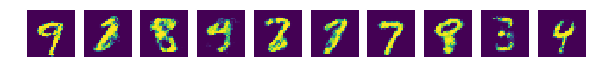

samples/009.png


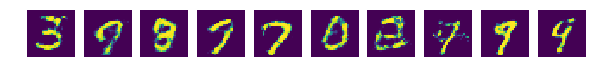

samples/019.png


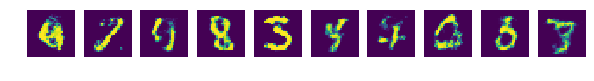

samples/029.png


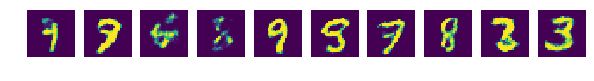

samples/039.png


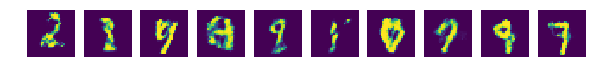

samples/049.png


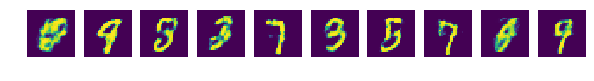

samples/059.png


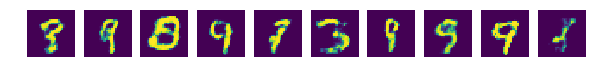

samples/069.png


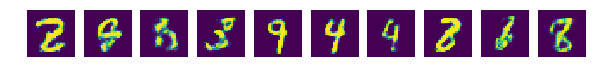

samples/079.png


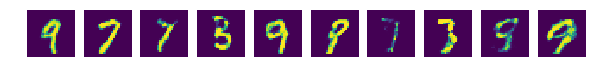

samples/089.png


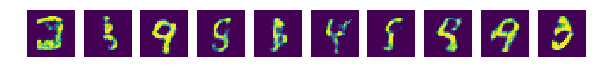

samples/099.png


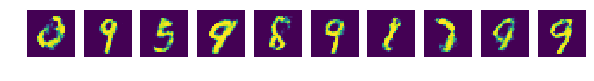

In [0]:
from IPython.display import display, Image 


step=['000','009','019','029','039','049','059','069','079','089','099']

for i in step:
  print('samples/{}.png'.format(i))
  display(Image('samples/{}.png'.format(i)))